In [9]:
# Sanity check current kernel and paths (enhanced)
import sys, site
try:
    import numpy as np
    numpy_ok = True
except ModuleNotFoundError:
    numpy_ok = False

exe = sys.executable
print("Python:", sys.version)
print("Executable:", exe)
print("NumPy available:", numpy_ok)
if numpy_ok:
    print("NumPy version:", np.__version__)
print("Site-packages root(s):", site.getsitepackages() if hasattr(site, 'getsitepackages') else 'n/a')

expected_suffix = "/.venv/bin/python"
if not exe.endswith(expected_suffix):
    print(f"[WARNING] Kernel is not using the project venv (expected endswith '{expected_suffix}').")
    print("If imports fail, re-select the kernel linked to .venv (Python 3.14).")
elif not numpy_ok:
    print("[WARNING] NumPy missing despite correct interpreter; try 'pip install -r requirements.txt' inside the venv.")
else:
    print("Environment check passed: using project .venv with NumPy.")

Python: 3.14.0 (main, Oct  7 2025, 09:34:52) [Clang 17.0.0 (clang-1700.0.13.3)]
Executable: /Users/uday/Documents/MATH4400/stochastic-correlation/.venv/bin/python
NumPy available: True
NumPy version: 2.3.5
Site-packages root(s): ['/Users/uday/Documents/MATH4400/stochastic-correlation/.venv/lib/python3.14/site-packages']
Environment check passed: using project .venv with NumPy.


Imports

In [10]:
import sys
import os
sys.path.append(os.path.join(os.getcwd(), 'src'))

import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import quad
from model_parameters import CorrelationProcess, ConvergenceModel
from pde_solver import CrankNicolsonSolver
from finite_differences import central_difference_first, central_difference_second
import matplotlib as mpl

# Set plotting style for publication-quality figures
mpl.rcParams['figure.figsize'] = [10, 6]
mpl.rcParams['font.size'] = 12
plt.style.use('seaborn-v0_8-whitegrid')

Cell 2: Define D(τ) and U(τ) functions from original Corzo-Schwartz model
[PLACEHOLDER: These are the closed-form solutions for D and U from the original model]

In [11]:
def D(tau, b):
    """Closed-form solution for D(τ) from Corzo-Schwartz model"""
    return (1 - np.exp(-b * tau)) / b

def U(tau, b, c):
    """Closed-form solution for U(τ) from Corzo-Schwartz model"""
    if np.isclose(b, c):
        return (1 - np.exp(-c * tau)) / c + (b / c) * tau * np.exp(-c * tau)
    else:
        term1 = (1 - np.exp(-c * tau)) / c
        term2 = (1 / (b - c)) * (np.exp(-b * tau) - np.exp(-c * tau))
        return term1 + term2

Cell 3: Define f1(τ) and f2(τ) functions from equations (3.6) and (3.7)
[PLACEHOLDER: These functions capture the deterministic parts of the bond pricing PDE]

In [12]:
def f1_func(tau, params):
    """f1 function from equation (3.6) - deterministic terms excluding correlation"""
    D_val = D(tau, params['b'])
    U_val = U(tau, params['b'], params['c'])
    
    term1 = -(params['a'] - params['lambda_d'] * params['sigma_d']) * D_val
    term2 = -(params['c'] * params['d'] - params['lambda_u'] * params['sigma_u']) * U_val
    term3 = 0.5 * params['sigma_d']**2 * D_val**2
    term4 = 0.5 * params['sigma_u']**2 * U_val**2
    
    return term1 + term2 + term3 + term4

def f2_func(tau, params):
    """f2 function from equation (3.7) - correlation-dependent term"""
    D_val = D(tau, params['b'])
    U_val = U(tau, params['b'], params['c'])
    return params['sigma_d'] * params['sigma_u'] * D_val * U_val

Cell 4: Initialize model parameters from paper Section 4
[PLACEHOLDER: Using the same parameters as the original paper for consistency]

In [13]:
# Convergence model parameters from Corzo-Schwartz (2000)
conv_params = {
    'a': 0.0938,
    'b': 3.67,
    'sigma_d': 0.032,
    'c': 0.2087,
    'd': 0.035, 
    'sigma_u': 0.016,
    'lambda_d': 3.315,
    'lambda_u': -0.655
}

# Stochastic correlation process parameters from Example 1
corr_params = CorrelationProcess(
    mu=0.1,
    sigma=0.25,
    lambda_corr=-5.0
)

print("Model parameters initialized:")
print(f"Convergence model: {conv_params}")
print(f"Correlation process: μ={corr_params.mu}, σ={corr_params.sigma}, λ_corr={corr_params.lambda_corr}")

Model parameters initialized:
Convergence model: {'a': 0.0938, 'b': 3.67, 'sigma_d': 0.032, 'c': 0.2087, 'd': 0.035, 'sigma_u': 0.016, 'lambda_d': 3.315, 'lambda_u': -0.655}
Correlation process: μ=0.1, σ=0.25, λ_corr=-5.0


In [14]:
# Cell 5: Create wrapper functions for f1 and f2 with fixed parameters
# [PLACEHOLDER: These wrappers adapt the functions for use in our PDE solver]

def f1_wrapper(tau):
    return f1_func(tau, conv_params)

def f2_wrapper(tau):
    return f2_func(tau, conv_params)

# Test the functions at a sample point
tau_test = 5.0
print(f"f1(τ={tau_test}) = {f1_wrapper(tau_test):.6f}")
print(f"f2(τ={tau_test}) = {f2_wrapper(tau_test):.6f}")

f1(τ=5.0) = -0.048854
f2(τ=5.0) = 0.000419


In [15]:
# Cell 6: Initialize and run the Crank-Nicolson PDE solver
# [PLACEHOLDER: Solving the full PDE for A(ρ,τ) with stochastic correlation]

print("Initializing Crank-Nicolson PDE solver...")
solver = CrankNicolsonSolver(
    rho_min=0.01, 
    rho_max=0.99, 
    n_rho=100, 
    tau_max=50, 
    n_tau=1000
)

solver.setup_system(corr_params, f1_wrapper, f2_wrapper)

print("Starting PDE solution...")
A_solution = solver.solve()
print(f"PDE solution completed. Shape: {A_solution.shape}")

Initializing Crank-Nicolson PDE solver...
Starting PDE solution...
Starting Crank-Nicolson solver...
Iteration 1: Residual norm = 1.22e-04, Update norm = 1.25e-04
Iteration 2: Residual norm = 1.66e-05, Update norm = 1.60e-05
Iteration 3: Residual norm = 2.23e-06, Update norm = 2.69e-06
Iteration 4: Residual norm = 8.00e-07, Update norm = 6.92e-07
Iteration 5: Residual norm = 1.82e-07, Update norm = 2.09e-07
Iteration 6: Residual norm = 4.81e-08, Update norm = 3.91e-08
Iteration 7: Residual norm = 1.59e-08, Update norm = 1.71e-08
Iteration 8: Residual norm = 3.09e-09, Update norm = 2.62e-09
Newton-Raphson converged in 8 iterations
Progress: 0.0%
Iteration 1: Residual norm = 6.47e-05, Update norm = 6.65e-05
Iteration 2: Residual norm = 8.85e-06, Update norm = 8.51e-06
Iteration 3: Residual norm = 1.19e-06, Update norm = 1.43e-06
Iteration 4: Residual norm = 4.25e-07, Update norm = 3.68e-07
Iteration 5: Residual norm = 9.70e-08, Update norm = 1.11e-07
Iteration 6: Residual norm = 2.56e-08

In [16]:
# Cell 7: Implement the series expansion from paper Section 3
# [PLACEHOLDER: Comparing our numerical solution with analytical series expansion]

def solve_series_expansion(tau_max, corr_params, conv_params, expansion_order=3):
    """Solve for A_i coefficients using the series expansion method"""
    from scipy.integrate import solve_ivp
    
    # Get expansion coefficients
    mu = corr_params.mu
    sigma = corr_params.sigma
    lambda_corr = corr_params.lambda_corr
    
    mu1 = mu - lambda_corr * sigma - sigma**2
    mu2 = -(mu - lambda_corr * sigma) + 2 * sigma**2
    mu3 = -sigma**2
    sigma2 = sigma**2
    sigma3 = -2 * sigma**2
    
    # Time points
    tau_eval = np.linspace(0, tau_max, 100)
    
    # ODE system for A_i coefficients
    def A_odes(tau, A):
        A0, A1, A2, A3 = A
        f1_val = f1_wrapper(tau)
        f2_val = f2_wrapper(tau)
        
        dA0 = f1_val + f2_val
        dA1 = -mu1 * A1 - f2_val
        dA2 = -(2*mu1 - sigma2) * A2 - mu2 * A1 + 0.5 * sigma2 * A1**2
        dA3 = -(3*mu1 - 3*sigma2) * A3 + (sigma3 - 2*mu2) * A2 + 2*sigma2 * A1 * A2 + 0.5 * sigma3 * A1**2 - mu3 * A1
        
        return [dA0, dA1, dA2, dA3]
    
    # Solve ODE system
    sol = solve_ivp(A_odes, [0, tau_max], [0, 0, 0, 0], t_eval=tau_eval, method='RK45')
    
    return sol.t, sol.y

# Compute series expansion solution
tau_series, A_series = solve_series_expansion(50, corr_params, conv_params)
print("Series expansion solution computed")

Series expansion solution computed


In [17]:
# Cell 8: Compare numerical PDE solution with series expansion
# [PLACEHOLDER: Quantitative comparison between full numerical solution and analytical approximation]

# Select a specific correlation value for comparison (ρ = 0.8 as in paper)
target_rho = 0.8
x = 1 - target_rho  # x = 1 - ρ
rho_idx = np.argmin(np.abs(solver.rho_grid - target_rho))

# Extract solutions at this correlation value
A_pde_at_rho = A_solution[:, rho_idx]
tau_pde = solver.tau_grid

# Get series expansion approximation at this correlation
A_series_at_rho = np.zeros(len(tau_series))
for i, tau in enumerate(tau_series):
    tau_idx = np.argmin(np.abs(tau_pde - tau))
    A0 = A_series[0, i]
    A1 = A_series[1, i] 
    A2 = A_series[2, i]
    A3 = A_series[3, i]
    A_series_at_rho[i] = A0 + A1*x + A2*x**2 + A3*x**3

print(f"Comparison prepared for ρ = {target_rho}")

Comparison prepared for ρ = 0.8


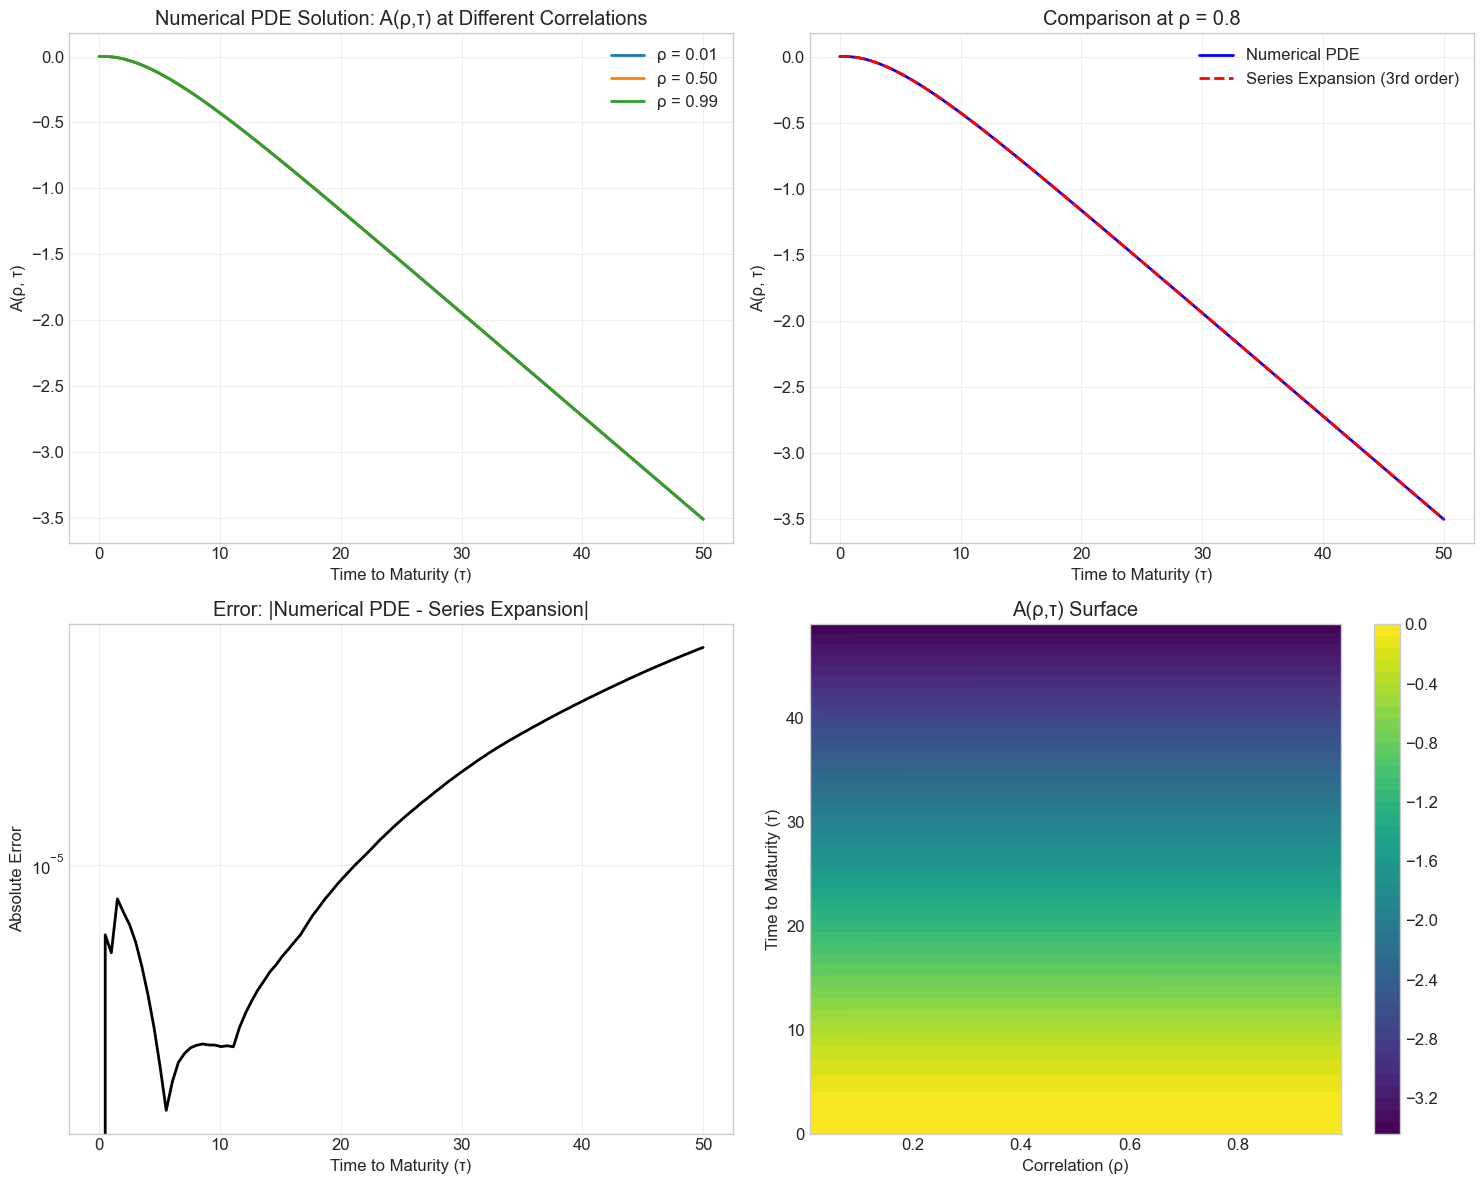

In [18]:
# Cell 9: Create comprehensive visualization of results
# [PLACEHOLDER: Visual comparison between numerical PDE solution and series expansion]

fig, axes = plt.subplots(2, 2, figsize=(15, 12))

# Plot 1: A(ρ,τ) evolution at different correlation values
rho_indices = [0, 49, 99]  # Low, medium, high correlation
for idx in rho_indices:
    axes[0,0].plot(tau_pde, A_solution[:, idx], 
                   label=f'ρ = {solver.rho_grid[idx]:.2f}', linewidth=2)
axes[0,0].set_xlabel('Time to Maturity (τ)')
axes[0,0].set_ylabel('A(ρ, τ)')
axes[0,0].set_title('Numerical PDE Solution: A(ρ,τ) at Different Correlations')
axes[0,0].legend()
axes[0,0].grid(True, alpha=0.3)

# Plot 2: Comparison at ρ = 0.8
axes[0,1].plot(tau_pde, A_pde_at_rho, 'b-', linewidth=2, label='Numerical PDE')
axes[0,1].plot(tau_series, A_series_at_rho, 'r--', linewidth=2, label='Series Expansion (3rd order)')
axes[0,1].set_xlabel('Time to Maturity (τ)')
axes[0,1].set_ylabel('A(ρ, τ)')
axes[0,1].set_title(f'Comparison at ρ = {target_rho}')
axes[0,1].legend()
axes[0,1].grid(True, alpha=0.3)

# Plot 3: Error between methods
# Interpolate to common time grid for error calculation
A_pde_interp = np.interp(tau_series, tau_pde, A_pde_at_rho)
error = A_pde_interp - A_series_at_rho

axes[1,0].semilogy(tau_series, np.abs(error), 'k-', linewidth=2)
axes[1,0].set_xlabel('Time to Maturity (τ)')
axes[1,0].set_ylabel('Absolute Error')
axes[1,0].set_title('Error: |Numerical PDE - Series Expansion|')
axes[1,0].grid(True, alpha=0.3)

# Plot 4: A(ρ,τ) surface plot
rho_mesh, tau_mesh = np.meshgrid(solver.rho_grid, tau_pde[::20])  # Downsample for clarity
A_mesh = A_solution[::20, :]

contour = axes[1,1].contourf(rho_mesh, tau_mesh, A_mesh, levels=50, cmap='viridis')
axes[1,1].set_xlabel('Correlation (ρ)')
axes[1,1].set_ylabel('Time to Maturity (τ)')
axes[1,1].set_title('A(ρ,τ) Surface')
plt.colorbar(contour, ax=axes[1,1])

plt.tight_layout()
plt.show()

In [19]:
# Cell 10: Compute bond prices using both methods
# [PLACEHOLDER: Convert A(ρ,τ) solutions to actual bond prices for financial interpretation]

def compute_bond_price(A_val, r_d, r_u, tau, params):
    """Compute bond price from A(ρ,τ), D(τ), U(τ)"""
    D_val = D(tau, params['b'])
    U_val = U(tau, params['b'], params['c'])
    return np.exp(A_val - D_val * r_d - U_val * r_u)

# Example: Compute bond prices for specific rates
r_d = 0.05  # Domestic short rate
r_u = 0.03  # Union short rate  
rho_test = 0.8

# Find corresponding A values
tau_examples = [5, 10, 15, 20, 25, 30]
bond_prices_pde = []
bond_prices_series = []

for tau in tau_examples:
    # PDE solution
    tau_idx = np.argmin(np.abs(tau_pde - tau))
    rho_idx = np.argmin(np.abs(solver.rho_grid - rho_test))
    A_pde = A_solution[tau_idx, rho_idx]
    price_pde = compute_bond_price(A_pde, r_d, r_u, tau, conv_params)
    bond_prices_pde.append(price_pde)
    
    # Series expansion solution
    tau_series_idx = np.argmin(np.abs(tau_series - tau))
    A0 = A_series[0, tau_series_idx]
    A1 = A_series[1, tau_series_idx]
    A2 = A_series[2, tau_series_idx] 
    A3 = A_series[3, tau_series_idx]
    A_series_val = A0 + A1*(1-rho_test) + A2*(1-rho_test)**2 + A3*(1-rho_test)**3
    price_series = compute_bond_price(A_series_val, r_d, r_u, tau, conv_params)
    bond_prices_series.append(price_series)

# Display results
print("Bond Price Comparison (r_d=5%, r_u=3%, ρ=0.8):")
print("Maturity | PDE Solution | Series Expansion | Difference")
print("-" * 55)
for i, tau in enumerate(tau_examples):
    diff = bond_prices_pde[i] - bond_prices_series[i]
    print(f"{tau:>4} yrs | {bond_prices_pde[i]:.6f}    | {bond_prices_series[i]:.6f}        | {diff:.2e}")

Bond Price Comparison (r_d=5%, r_u=3%, ρ=0.8):
Maturity | PDE Solution | Series Expansion | Difference
-------------------------------------------------------
   5 yrs | 0.793262    | 0.791512        | 1.75e-03
  10 yrs | 0.567839    | 0.564341        | 3.50e-03
  15 yrs | 0.391599    | 0.387632        | 3.97e-03
  20 yrs | 0.266587    | 0.262881        | 3.71e-03
  25 yrs | 0.181368    | 0.184607        | -3.24e-03
  30 yrs | 0.122718    | 0.124476        | -1.76e-03


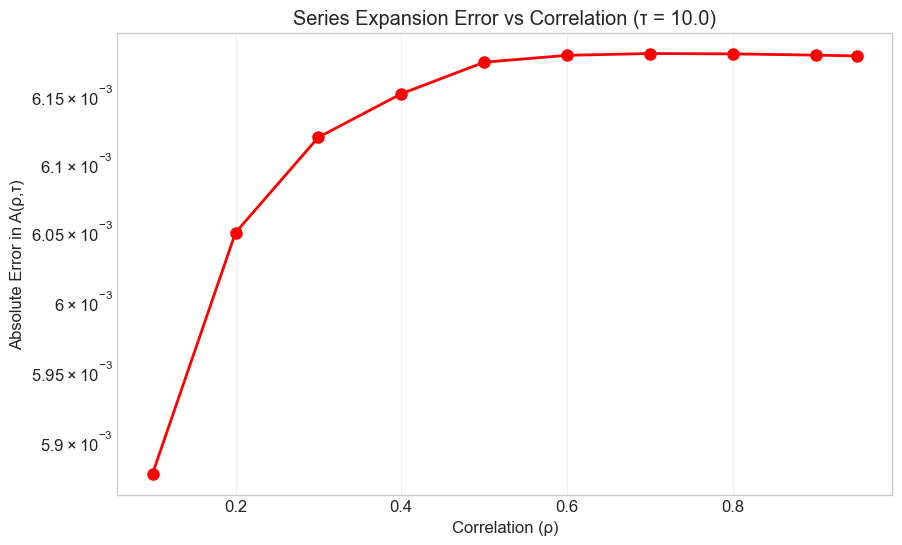

Error analysis completed - series expansion accuracy improves as ρ → 1


In [21]:
# Cell 11: Error analysis and convergence study
# [PLACEHOLDER: Systematic analysis of approximation errors across correlation values]

# Analyze how error changes with correlation
rho_test_values = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 0.95]
tau_fixed = 10.0
errors_vs_rho = []

for rho in rho_test_values:
    x = 1 - rho
    
    # PDE solution
    tau_idx = np.argmin(np.abs(tau_pde - tau_fixed))
    rho_idx = np.argmin(np.abs(solver.rho_grid - rho))
    A_pde = A_solution[tau_idx, rho_idx]
    
    # Series expansion
    tau_series_idx = np.argmin(np.abs(tau_series - tau_fixed))
    A0 = A_series[0, tau_series_idx]
    A1 = A_series[1, tau_series_idx]
    A2 = A_series[2, tau_series_idx]
    A3 = A_series[3, tau_series_idx]
    A_series_val = A0 + A1*x + A2*x**2 + A3*x**3
    
    error = abs(A_pde - A_series_val)
    errors_vs_rho.append(error)

# Plot error vs correlation
plt.figure(figsize=(10, 6))
plt.semilogy(rho_test_values, errors_vs_rho, 'ro-', linewidth=2, markersize=8)
plt.xlabel('Correlation (ρ)')
plt.ylabel('Absolute Error in A(ρ,τ)')
plt.title(f'Series Expansion Error vs Correlation (τ = {tau_fixed})')
plt.grid(True, alpha=0.3)
plt.show()

print("Error analysis completed - series expansion accuracy improves as ρ → 1")